<a href="https://colab.research.google.com/github/calistasalscpw/Selena-Finance-Tracker/blob/main/Selena_Shopee_rev_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capstone Project - Selena (Shopee)

**Proses Analisis oleh Model ML (Menggunakan File .pkl)**

- **Backend kemudian memuat model ML yang sudah dilatih (disimpan dalam format .pkl) menggunakan library Pickle di Python.**
- Model ML ini memproses data transaksi pengguna yang sudah diambil dari database untuk melakukan beberapa tugas analisis:
    - Arus Kas: Mengidentifikasi pola pemasukan dan pengeluaran.
    - Saran Keuangan: Berdasarkan analisis tren keuangan pengguna, model bisa memberikan saran, misalnya mengurangi pengeluaran di kategori tertentu.
    - Deteksi Anomali Pengeluaran: Model ML mendeteksi adanya transaksi atau pengeluaran yang tidak biasa atau mencurigakan.

Pengembalian Hasil Analisis ke Backend (ML ke CC)

- Model ML menghasilkan output analisis, seperti rekomendasi keuangan atau deteksi anomali, yang dikonversi ke **format JSON**.
- Backend menerima hasil ini dan menggabungkannya menjadi satu respons JSON yang siap dikirim ke aplikasi mobile.

## Import Libraries

In [13]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter 
import pandas as pd

Convert .xlsx to .csv 

In [14]:
read_file = pd.read_excel("./data/Order.completed.20240903_20241003.xlsx")
read_file.to_csv("./data/Order.completed.20240903_20241003.csv", index=None, header=True)
df = pd.DataFrame(pd.read_csv("./data/Order.completed.20240903_20241003.csv"))
print(df.head())

      No. Pesanan Status Pesanan Status Pembatalan/ Pengembalian  \
0  24090319KKAFE8        Selesai                             NaN   
1  2409043YH69NTF        Selesai                             NaN   
2  2409031QMAU0WH        Selesai                             NaN   
3  24090449E4N3U0        Selesai                             NaN   
4  2409069M51V33M        Selesai                             NaN   

            No. Resi                  Opsi Pengiriman  \
0  SPXID040285869389  Reguler (Cashless)-SPX Standard   
1  SPXID047799706439  Reguler (Cashless)-SPX Standard   
2  SPXID045570814139  Reguler (Cashless)-SPX Standard   
3      CM93203860375   Reguler (Cashless)-JNE Reguler   
4  SPXID048740532539  Reguler (Cashless)-SPX Standard   

  Antar ke counter/ pick-up  \
0          Antar ke Counter   
1          Antar ke Counter   
2          Antar ke Counter   
3          Antar ke Counter   
4          Antar ke Counter   

  Pesanan Harus Dikirimkan Sebelum (Menghindari keterlambatan

Open data. Path to be determined.

In [15]:
DATA_PATH = './data/Order.completed.20240903_20241003.csv' # format data .csv

with open(DATA_PATH, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

No. Pesanan,Status Pesanan,Status Pembatalan/ Pengembalian,No. Resi,Opsi Pengiriman,Antar ke counter/ pick-up,Pesanan Harus Dikirimkan Sebelum (Menghindari keterlambatan),Waktu Pengiriman Diatur,Waktu Pesanan Dibuat,Waktu Pembayaran Dilakukan,Metode Pembayaran,SKU Induk,Nama Produk,Nomor Referensi SKU,Nama Variasi,Harga Awal,Harga Setelah Diskon,Jumlah,Returned quantity,Total Harga Produk,Total Diskon,Diskon Dari Penjual,Diskon Dari Shopee,Berat Produk,Jumlah Produk di Pesan,Total Berat,Voucher Ditanggung Penjual,Cashback Koin,Voucher Ditanggung Shopee,Paket Diskon,Paket Diskon (Diskon dari Shopee),Paket Diskon (Diskon dari Penjual),Potongan Koin Shopee,Diskon Kartu Kredit,Ongkos Kirim Dibayar oleh Pembeli,Estimasi Potongan Biaya Pengiriman,Ongkos Kirim Pengembalian Barang,Total Pembayaran,Perkiraan Ongkos Kirim,Catatan dari Pembeli,Catatan,Username (Pembeli),Nama Penerima,No. Telepon,Alamat Pengiriman,Kota/Kabupaten,Provinsi,Waktu Pesanan Selesai

First data p

In [16]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Date")
    plt.ylabel("Income")
    plt.grid(True)

This dataset is using times and temperature only, so needs adjustment

In [17]:
def parse_data_from_file(filename):
    """Parse data from csv file

    Args:
        filename (str): complete path to file (path + filename)

    Returns:
        (np.ndarray, np.ndarray): arrays of timestamps and values of the time series
    """

    # Load the temperatures using np.loadtxt. We want to skip the first
    # row, since it's headers. Make sure to use the correct column of the csv file.
    #temperatures = np.loadtxt(filename, dtype='float', delimiter=',', skiprows=1, usecols=1)
    #times = np.arange(len(temperatures)) # Create the time steps.

    order_date = df['Waktu Pesanan Selesai'].tolist()
    payment = df['Total Pembayaran'].tolist()

    return order_date, payment

In [18]:
TIME, SERIES = parse_data_from_file(DATA_PATH)

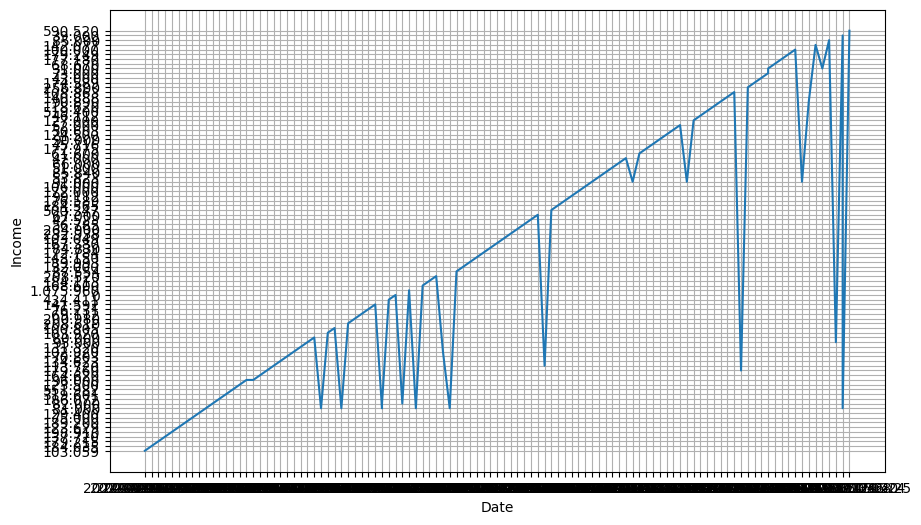

In [19]:
#Plot series

fig, ax = plt.subplots(figsize=(10, 6))
DateFormatter('%m-%d')
plot_series(TIME, SERIES)

Global Variables

In [20]:
SPLIT_TIME = 2500
WINDOW_SIZE = 64
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

## Processing the Data

In [21]:
def train_val_split(time, series):
    """Split time series into train and validation sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [22]:
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

In [26]:
def windowed_dataset(series, window_size):
    """Creates window dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)

    return dataset

In [27]:
#Apply transformation to training set
train_dataset = windowed_dataset(series_train, window_size=WINDOW_SIZE)

## Model Architecture

In [36]:
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(WINDOW_SIZE, 1)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    return model

In [37]:
uncompiled_model = create_uncompiled_model()

In [38]:
example_batch = train_dataset.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.


In [39]:
uncompiled_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 64, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,933 (70.05 KB)

 Trainable params: 17,933 (70.05 KB)

 Non-trainable params: 0 (0.00 B)